# EfficientNet
- 데이터를 불러올 때 augraphy 수행

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import timm
import torch
import albumentations as A
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from albumentations.core.transforms_interface import ImageOnlyTransform
from augraphy import *

from sklearn.metrics import accuracy_score, f1_score

import wandb

In [2]:
wandb.login(key='')
run = wandb.init(project='CV_contest_V13', name='training')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: greedjar74 (greedjar7498). Use `wandb login --relogin` to force relogin


In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

# CustomDataset

In [12]:
class customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms, pipeline):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms
        self.pipeline = pipeline

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.pipeline(img)
        img = self.transforms(img)
    
        return img, target

In [13]:
class RandomPadding:
    def __init__(self, padding_range=(0, 50), fill=0):
        self.padding_range = padding_range
        self.fill = fill

    def __call__(self, image):
        # 각 방향에 대해 랜덤한 패딩 값 생성
        pad_top = random.randint(*self.padding_range)
        pad_bottom = random.randint(*self.padding_range)
        pad_left = random.randint(*self.padding_range)
        pad_right = random.randint(*self.padding_range)
        
        # 패딩 추가
        padding = (pad_left, pad_top, pad_right, pad_bottom)
        return T.functional.pad(image, padding, fill=self.fill)

In [25]:
augmentations = [
    NoiseTexturize(sigma_range=(6, 10),
                  turbulence_range=(5, 10),
                  texture_width_range=(50, 500),
                  texture_height_range=(50, 500)),
    BrightnessTexturize(texturize_range=(0.9, 0.99), deviation=0.2),
    ReflectedLight(reflected_light_smoothness = 0.8,
                   reflected_light_internal_radius_range=(0.0, 0.2),
                   reflected_light_external_radius_range=(0.1, 0.8),
                   reflected_light_minor_major_ratio_range = (0.9, 1.0),
                   reflected_light_color = tuple(np.random.randint(0, 256, size=3)),
                   reflected_light_internal_max_brightness_range=(0.9,1.0),
                   reflected_light_external_max_brightness_range=(0.9,0.9),
                   reflected_light_location = "random",
                   reflected_light_ellipse_angle_range = (0, 360),
                   reflected_light_gaussian_kernel_size_range = (5,10)),
    Folding(fold_count=2,
            fold_noise=0.0,
            fold_angle_range = (-180,180),
            gradient_width=(0.01, 0.05),
            gradient_height=(0.01, 0.05),
            backdrop_color = (0,0,0))
]

aug_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    RandomPadding(padding_range=(10, 20), fill=50),  # 랜덤 패딩 추가
    T.RandomResizedCrop(size=(380,380), scale=(0.5, 1.0)),
])

simple_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.Resize((380, 380))
])

origin_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((380, 380))
    ])

pipeline = AugraphyPipeline(augmentations)
pipeline2 = AugraphyPipeline()

aug_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=aug_transforms, pipeline=pipeline)

simple_aug_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms, pipeline=pipeline2)

origin_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms, pipeline=pipeline2)

In [26]:
train_dataset = torch.utils.data.ConcatDataset([aug_dataset_1,

                                                simple_aug_dataset_1, 

                                                origin_dataset_1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


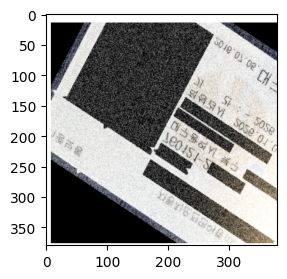

In [34]:
plt.figure(figsize=(3, 3))
plt.imshow(train_dataset[10][0].permute(1, 2, 0))
plt.show()

In [36]:
valid_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((380, 380))
])

valid_dataset = customdataset('/data/ephemeral/home/preds/calibrated_preds.csv', '/data/ephemeral/home/data/test/', transforms=valid_transforms, pipeline=pipeline2) # valid dataset

In [37]:
len(valid_dataset)

3140

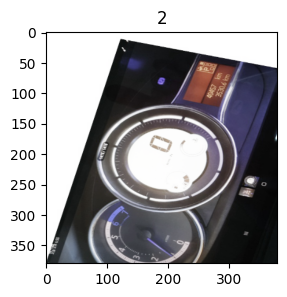

In [38]:
plt.figure(figsize=(3, 3))
plt.imshow(valid_dataset[0][0].permute(1, 2, 0))
plt.title(valid_dataset[0][1])
plt.show()

In [39]:
print(len(train_dataset))
print(len(valid_dataset))

4710
3140


In [40]:
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=8)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=8)

# 학습

In [41]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evalutaion(model, valid_dataloader, valid_accuracy, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    best_valid_loss = float('inf')
    early_stop_cnt = 0
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evalutaion(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        monitoring_values = {'Train Loss': train_loss, 'Valid Loss': valid_loss, 'Train Accuracy': train_accuracy, 'Valid Accuracy': valid_accuracy}
        run.log(monitoring_values, step=epoch)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v13_best.pt")
            best_valid_loss = valid_loss
            early_stop_cnt = 0

        else :
            early_stop_cnt += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        if early_stop_cnt >= 50:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v13_last.pt")
            print('Early Stopping')
            break

    return model

In [42]:
model = timm.create_model(
    'efficientnet_b4',
    pretrained=True,
    num_classes=17
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [43]:
model = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 500)

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [1/500], Train Loss: 0.7034, Train Accuracy: 0.7618 Valid Loss: 0.5750, Valid Accuracy: 0.8006


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [2/500], Train Loss: 0.3103, Train Accuracy: 0.8909 Valid Loss: 0.4545, Valid Accuracy: 0.8525


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [3/500], Train Loss: 0.2094, Train Accuracy: 0.9248 Valid Loss: 0.3749, Valid Accuracy: 0.8697


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [4/500], Train Loss: 0.1628, Train Accuracy: 0.9435 Valid Loss: 0.4482, Valid Accuracy: 0.8634


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [5/500], Train Loss: 0.1546, Train Accuracy: 0.9467 Valid Loss: 0.4131, Valid Accuracy: 0.8666


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [6/500], Train Loss: 0.1470, Train Accuracy: 0.9469 Valid Loss: 0.4279, Valid Accuracy: 0.8646


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [7/500], Train Loss: 0.1331, Train Accuracy: 0.9535 Valid Loss: 0.4890, Valid Accuracy: 0.8430


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [8/500], Train Loss: 0.1269, Train Accuracy: 0.9550 Valid Loss: 0.3698, Valid Accuracy: 0.8854


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [9/500], Train Loss: 0.1036, Train Accuracy: 0.9628 Valid Loss: 0.3553, Valid Accuracy: 0.8857


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [10/500], Train Loss: 0.1013, Train Accuracy: 0.9637 Valid Loss: 0.5345, Valid Accuracy: 0.8599


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [11/500], Train Loss: 0.0890, Train Accuracy: 0.9690 Valid Loss: 0.4171, Valid Accuracy: 0.8713


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [12/500], Train Loss: 0.0876, Train Accuracy: 0.9694 Valid Loss: 0.5738, Valid Accuracy: 0.8481


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [13/500], Train Loss: 0.1090, Train Accuracy: 0.9624 Valid Loss: 0.5468, Valid Accuracy: 0.8596


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [14/500], Train Loss: 0.0796, Train Accuracy: 0.9739 Valid Loss: 0.4876, Valid Accuracy: 0.8701


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [15/500], Train Loss: 0.0664, Train Accuracy: 0.9783 Valid Loss: 0.4752, Valid Accuracy: 0.8707


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [16/500], Train Loss: 0.0711, Train Accuracy: 0.9781 Valid Loss: 0.3509, Valid Accuracy: 0.8952


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [17/500], Train Loss: 0.0712, Train Accuracy: 0.9739 Valid Loss: 0.5133, Valid Accuracy: 0.8717


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [18/500], Train Loss: 0.0704, Train Accuracy: 0.9754 Valid Loss: 0.3894, Valid Accuracy: 0.8943


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [19/500], Train Loss: 0.0664, Train Accuracy: 0.9777 Valid Loss: 0.4419, Valid Accuracy: 0.8764


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [20/500], Train Loss: 0.0568, Train Accuracy: 0.9794 Valid Loss: 0.5297, Valid Accuracy: 0.8768


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [21/500], Train Loss: 0.0511, Train Accuracy: 0.9843 Valid Loss: 0.4813, Valid Accuracy: 0.8783


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [22/500], Train Loss: 0.0494, Train Accuracy: 0.9845 Valid Loss: 0.5100, Valid Accuracy: 0.8710


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [23/500], Train Loss: 0.0906, Train Accuracy: 0.9699 Valid Loss: 0.5614, Valid Accuracy: 0.8561


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [24/500], Train Loss: 0.0518, Train Accuracy: 0.9811 Valid Loss: 0.4279, Valid Accuracy: 0.8873


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [25/500], Train Loss: 0.0583, Train Accuracy: 0.9815 Valid Loss: 0.4388, Valid Accuracy: 0.8831


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [26/500], Train Loss: 0.0617, Train Accuracy: 0.9779 Valid Loss: 0.7159, Valid Accuracy: 0.8513


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [27/500], Train Loss: 0.0388, Train Accuracy: 0.9866 Valid Loss: 0.5057, Valid Accuracy: 0.8707


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [28/500], Train Loss: 0.0408, Train Accuracy: 0.9866 Valid Loss: 0.6273, Valid Accuracy: 0.8592


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [29/500], Train Loss: 0.0665, Train Accuracy: 0.9800 Valid Loss: 0.5299, Valid Accuracy: 0.8653


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [30/500], Train Loss: 0.0582, Train Accuracy: 0.9805 Valid Loss: 0.5885, Valid Accuracy: 0.8637


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [31/500], Train Loss: 0.0403, Train Accuracy: 0.9860 Valid Loss: 0.7261, Valid Accuracy: 0.8621


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [32/500], Train Loss: 0.0409, Train Accuracy: 0.9877 Valid Loss: 0.8096, Valid Accuracy: 0.8471


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [33/500], Train Loss: 0.0437, Train Accuracy: 0.9862 Valid Loss: 0.7097, Valid Accuracy: 0.8532


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [34/500], Train Loss: 0.0475, Train Accuracy: 0.9858 Valid Loss: 0.6863, Valid Accuracy: 0.8548


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [35/500], Train Loss: 0.0450, Train Accuracy: 0.9858 Valid Loss: 0.5117, Valid Accuracy: 0.8831


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [36/500], Train Loss: 0.0402, Train Accuracy: 0.9870 Valid Loss: 0.6605, Valid Accuracy: 0.8481


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [37/500], Train Loss: 0.0470, Train Accuracy: 0.9847 Valid Loss: 0.5252, Valid Accuracy: 0.8643


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [38/500], Train Loss: 0.0623, Train Accuracy: 0.9813 Valid Loss: 0.7493, Valid Accuracy: 0.8478


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [39/500], Train Loss: 0.0487, Train Accuracy: 0.9830 Valid Loss: 0.5110, Valid Accuracy: 0.8809


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [40/500], Train Loss: 0.0604, Train Accuracy: 0.9820 Valid Loss: 0.6890, Valid Accuracy: 0.8608


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [41/500], Train Loss: 0.0347, Train Accuracy: 0.9875 Valid Loss: 0.4664, Valid Accuracy: 0.8904


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [42/500], Train Loss: 0.0276, Train Accuracy: 0.9907 Valid Loss: 0.5596, Valid Accuracy: 0.8729


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [43/500], Train Loss: 0.0352, Train Accuracy: 0.9881 Valid Loss: 0.5419, Valid Accuracy: 0.8831


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [44/500], Train Loss: 0.0286, Train Accuracy: 0.9890 Valid Loss: 0.6382, Valid Accuracy: 0.8777


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [45/500], Train Loss: 0.0585, Train Accuracy: 0.9809 Valid Loss: 0.6066, Valid Accuracy: 0.8678


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [46/500], Train Loss: 0.0472, Train Accuracy: 0.9854 Valid Loss: 0.6926, Valid Accuracy: 0.8232


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [47/500], Train Loss: 0.0346, Train Accuracy: 0.9890 Valid Loss: 0.5249, Valid Accuracy: 0.8694


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [48/500], Train Loss: 0.0238, Train Accuracy: 0.9915 Valid Loss: 0.5878, Valid Accuracy: 0.8675


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [49/500], Train Loss: 0.0385, Train Accuracy: 0.9870 Valid Loss: 0.5852, Valid Accuracy: 0.8602


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [50/500], Train Loss: 0.0363, Train Accuracy: 0.9879 Valid Loss: 0.4968, Valid Accuracy: 0.8904


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [51/500], Train Loss: 0.0398, Train Accuracy: 0.9881 Valid Loss: 0.6994, Valid Accuracy: 0.8487


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [52/500], Train Loss: 0.0327, Train Accuracy: 0.9898 Valid Loss: 0.5889, Valid Accuracy: 0.8799


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [53/500], Train Loss: 0.0352, Train Accuracy: 0.9890 Valid Loss: 0.5548, Valid Accuracy: 0.8621


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [54/500], Train Loss: 0.0276, Train Accuracy: 0.9902 Valid Loss: 0.5072, Valid Accuracy: 0.8850


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [55/500], Train Loss: 0.0363, Train Accuracy: 0.9890 Valid Loss: 0.7525, Valid Accuracy: 0.8309


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [56/500], Train Loss: 0.0370, Train Accuracy: 0.9887 Valid Loss: 0.5626, Valid Accuracy: 0.8605


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [57/500], Train Loss: 0.0451, Train Accuracy: 0.9851 Valid Loss: 0.5722, Valid Accuracy: 0.8589


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [58/500], Train Loss: 0.0249, Train Accuracy: 0.9913 Valid Loss: 0.5606, Valid Accuracy: 0.8825


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [59/500], Train Loss: 0.0336, Train Accuracy: 0.9900 Valid Loss: 0.7340, Valid Accuracy: 0.8500


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [60/500], Train Loss: 0.0300, Train Accuracy: 0.9902 Valid Loss: 0.7351, Valid Accuracy: 0.8506


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [61/500], Train Loss: 0.0383, Train Accuracy: 0.9862 Valid Loss: 0.9306, Valid Accuracy: 0.7876


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [62/500], Train Loss: 0.0479, Train Accuracy: 0.9830 Valid Loss: 0.6604, Valid Accuracy: 0.8624


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [63/500], Train Loss: 0.0243, Train Accuracy: 0.9913 Valid Loss: 0.6775, Valid Accuracy: 0.8494


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [64/500], Train Loss: 0.0310, Train Accuracy: 0.9898 Valid Loss: 0.5721, Valid Accuracy: 0.8812


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [65/500], Train Loss: 0.0356, Train Accuracy: 0.9883 Valid Loss: 0.5321, Valid Accuracy: 0.8930


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [66/500], Train Loss: 0.0312, Train Accuracy: 0.9900 Valid Loss: 0.5072, Valid Accuracy: 0.8834
Early Stopping


In [44]:
wandb.finish()

Train Accuracy,▁▅▇▇▇▇▇▇▇█▇█████████████████████████████
Train Loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Accuracy,▂▅▆▆▅▇▆▅▆█▆▇▇▆▇▅▆▆▆▅▅▅▆▇█▇▇▃▆▆▅▇▇▆▆▅▁▆▇▇
Valid Loss,▄▂▂▂▃▁▂▄▃▁▃▂▃▃▂▅▃▃▆▇▅▅▃▃▂▄▄▅▃▄▅▄▃▄▄▆█▅▄▃
Train Accuracy,0.99002
Train Loss,0.0312
Valid Accuracy,0.88344
Valid Loss,0.50715


# Submission

In [5]:
model = timm.create_model(
    'efficientnet_b4',
    pretrained=True,
    num_classes=17
).to(device)
model.load_state_dict(torch.load('/data/ephemeral/home/model/models/model_v13_last.pt'))
criterion = torch.nn.CrossEntropyLoss()

In [6]:
class sub_customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [7]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((480, 480))
])

sub_dataset = sub_customdataset('/data/ephemeral/home/data/sample_submission.csv', '/data/ephemeral/home/data/test/', transforms=transforms)

In [8]:
batch_size = 16

sub_dataloader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

In [9]:
model.eval()

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    tbar = tqdm(sub_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        max_prob, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted)
        all_labels.extend(labels)
        all_images.extend(images)


  0%|          | 0/197 [00:00<?, ?it/s]

In [10]:
all_preds

[tensor(2, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(7, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(9, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(7, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(14, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(2, device='cuda:0'),
 

In [11]:
sub_df = pd.read_csv('/data/ephemeral/home/data/sample_submission.csv')
sub_df

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,0
4,00901f504008d884.jpg,0
...,...,...
3135,ffb4b6f619fb60ea.jpg,0
3136,ffb54299b1ad4159.jpg,0
3137,ffc2c91dff8cf2c0.jpg,0
3138,ffc4e330a5353a2a.jpg,0


In [12]:
for i in range(3140):
    sub_df.iloc[i, 1] = int(all_preds[i].cpu())

In [13]:
cnt_list = []
for i in range(17):
    cnt_list.append(sub_df[sub_df['target']==i].shape[0])

cnt_list

[278,
 83,
 209,
 101,
 168,
 185,
 173,
 294,
 175,
 189,
 258,
 220,
 188,
 146,
 83,
 198,
 192]

In [14]:
sub_df.to_csv('/data/ephemeral/home/preds/v13_last_preds.csv', index=False)